## Vision por computadora 1 - FIUBA
## 17Co2024
## Autores: Joaquín Matías Mestanza, Gonzalo Nicolas Silva Caggiano, Ramiro Andrés Feichubuinm

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)
    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
    de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
    donde se detecta la condición de máximo enfoque.


### Implementación

In [1]:
import numpy as np
from networkx import radius
from numpy.fft import fftshift, fft2
import cv2
import matplotlib.pyplot as plt

In [2]:
def image_quality_measure(gray_img):
    m, n = gray_img.shape
    F = fft2(gray_img)
    Fc = fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    thres = M/1000
    Th = np.sum(AF > thres)
    return Th/(m*n)

### Verificación

In [3]:
from utils import get_gray_img
lena_gray = get_gray_img(cv2.imread('lena.png'))
lena_gray.shape

(512, 512)

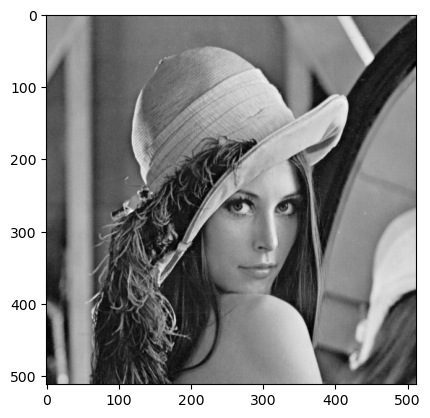

In [4]:
plt.imshow(lena_gray, cmap='gray')

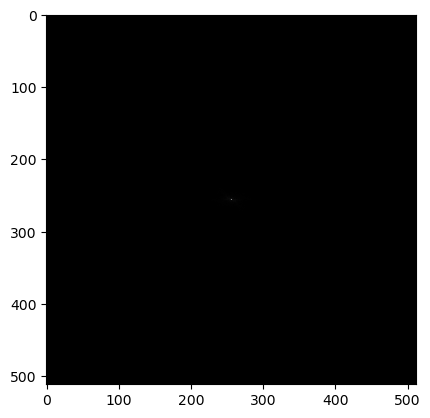

In [5]:
spectrum = np.abs(fftshift(fft2(lena_gray)))
plt.imshow(spectrum, cmap='gray')

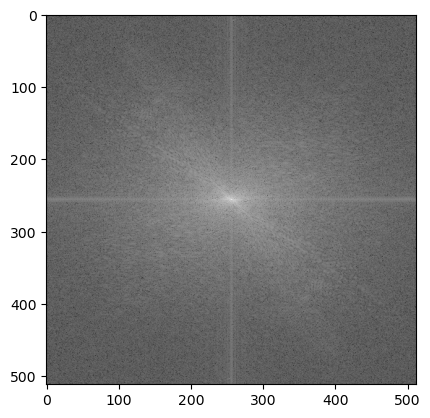

In [6]:
plt.imshow(np.log2(1+abs(spectrum)), cmap='gray')

In [7]:
image_quality_measure(lena_gray)

0.018215179443359375

Este valor coincide con el del trabajo publicado, es decir que el algoritmo se encuentra implementado correctamente.
Sin embargo, se ve que cuando se quiere realizar la estimación del espectro, es distinta a la que se muestra en el paper. Esto puede ser debido a que se utilizó otra imagen de lena (podría ser de menor dimensión) o se realizó una estimación espectral con algun tipo de filtro adicional. 

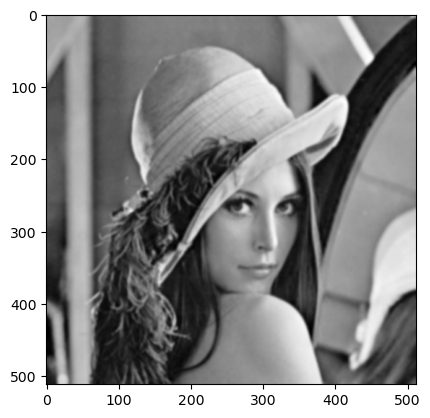

In [8]:
filtered_image = cv2.GaussianBlur(lena_gray, (7,7), 0)
plt.imshow(filtered_image, cmap='gray')

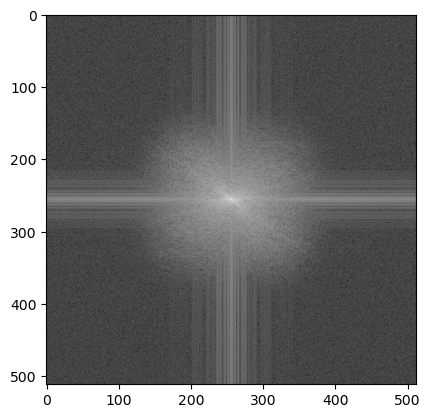

In [9]:
plt.imshow(np.log(1+np.abs(fftshift(fft2(filtered_image)))), cmap='gray')

In [10]:
image_quality_measure(filtered_image)

0.013317108154296875

Aquí se ve que cuando se aplica un GaussianBlur, la métrica disminuye, lo cual también es un comportamiento esperado.

### 1.1. Medición sobre todo el frame.

In [11]:
from utils import read_video_and_store_frames
fps, frame_paths = read_video_and_store_frames('focus_video.MOV')

Frames folders already created.
Storing video frames...
Frames stored successfully


In [12]:
frame_paths[:5] # muestra los primeros 5

['frames/frame-001.jpg',
 'frames/frame-002.jpg',
 'frames/frame-003.jpg',
 'frames/frame-004.jpg',
 'frames/frame-005.jpg']

In [13]:
metrics = [image_quality_measure(get_gray_img(cv2.imread(frame))) for frame in frame_paths]

1. Medición sobre todo el frame

In [14]:
from utils import plot_metric

0.028684895833333335

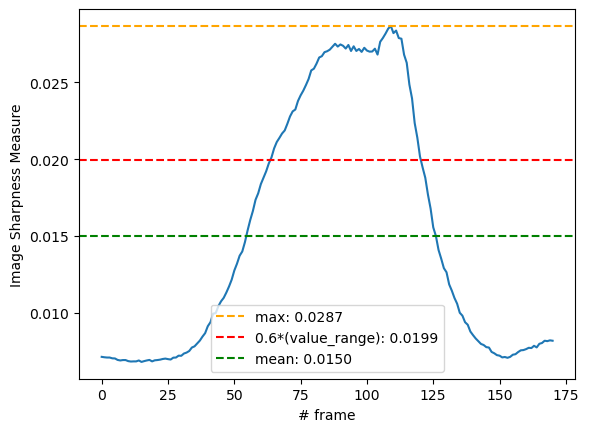

In [15]:
plot_metric(metrics)

Set de imagen de referencia.

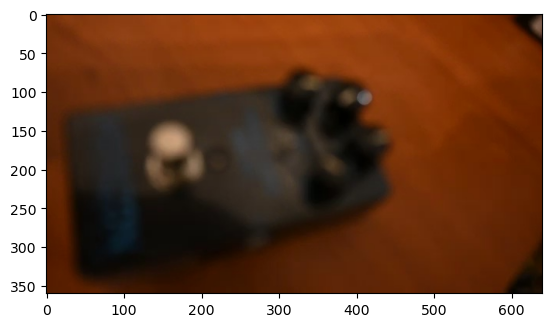

In [16]:
from utils import bgr_to_rgb
original = bgr_to_rgb(frame_paths[0])
plt.imshow(original)

 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del área total del frame.

ROI del 5%.

In [17]:
from utils import get_metric_for_centered_roi
metrics_roi_5_percent = [get_metric_for_centered_roi(cv2.imread(frame), image_quality_measure, 0.05) for frame in frame_paths]

0.9756944444444444

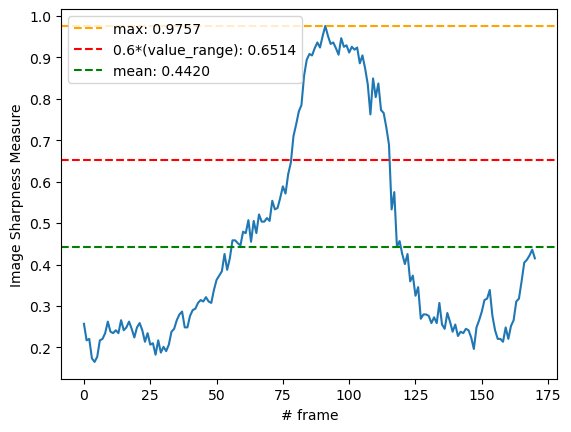

In [18]:
plot_metric(metrics_roi_5_percent)

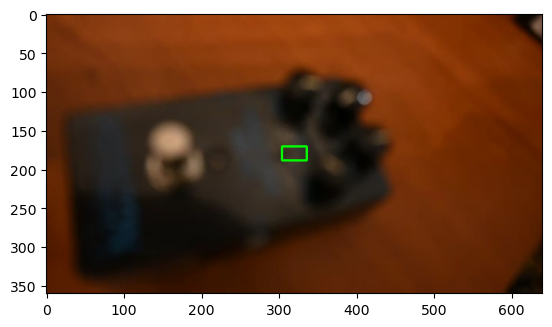

In [19]:
from utils import get_focus_matrix, get_centered_roi, draw_focus_matrix, write_video, get_value_range
dn, dm = get_centered_roi(get_gray_img(original), 0.05, return_rect_dims= True)
modified_roi_5, points_roi_5 = get_focus_matrix(original, rects_i=1, rects_j=1, dj=dm, di=dn)
plt.imshow(modified_roi_5)

La razón por la que cambió la métrica es porque el roi de 5% es parte del objeto, en específico la superficie del plástico contenedor.

Cuando se realiza la medición sobre toda la imagen, es posible que en algunos momentos el fondo esté desenfocado y el objeto también, o que el objeto esté enfocado y el fondo no.

Si el objetivo es detectar el enfoque del objeto, entonces conviene esta configuración.

In [20]:
focused_roi_5 = [draw_focus_matrix(frame, get_value_range(metrics_roi_5_percent), points_roi_5, image_quality_measure) for frame in frame_paths]
write_video('output_roi_5.mp4', focused_roi_5, fps)

ROI del 10%

In [21]:
metrics_roi_10_percent = [get_metric_for_centered_roi(cv2.imread(frame), image_quality_measure, 0.10) for frame in frame_paths]

0.7560763888888888

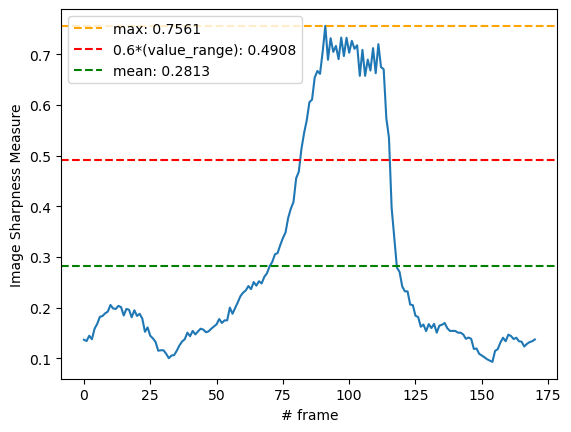

In [22]:
plot_metric(metrics_roi_10_percent)

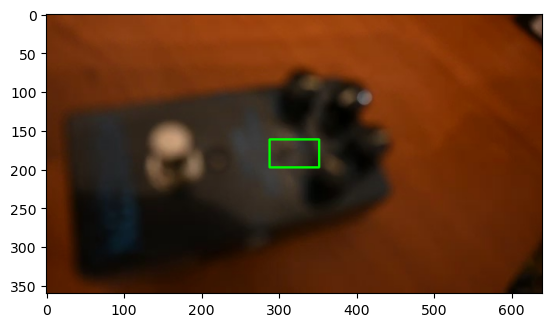

In [23]:
dn, dm = get_centered_roi(get_gray_img(original), 0.10, return_rect_dims=True)
modified_roi_10, points_roi_10 = get_focus_matrix(original, rects_i=1, rects_j=1, dj=dm, di=dn)
plt.imshow(modified_roi_10)

In [24]:
focused_roi_10 = [draw_focus_matrix(frame, get_value_range(metrics_roi_10_percent), points_roi_10, image_quality_measure) for frame in frame_paths]
write_video('output_roi_10.mp4', focused_roi_10, fps)

En este caso en el área de interés se superponen la perilla con el contenedor.

3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

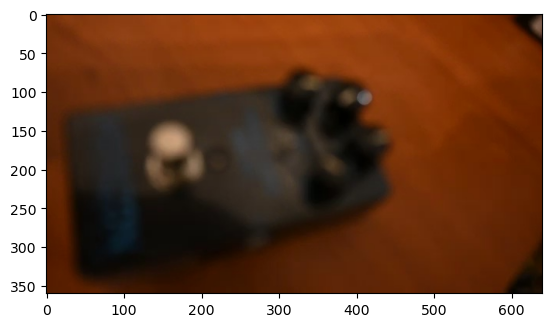

In [25]:
from utils import bgr_to_rgb
original = bgr_to_rgb(frame_paths[0])
plt.imshow(original)

In [26]:
from utils import get_focus_matrix

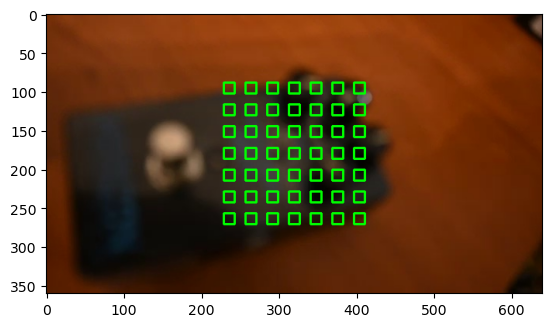

In [27]:
modified_7x7, points_7x7 = get_focus_matrix(original, rects_i=7, rects_j=7, dj=7, di=7)
plt.imshow(modified_7x7)

Se verifica que tiene un comportamiento similar a la imagen en la consigna

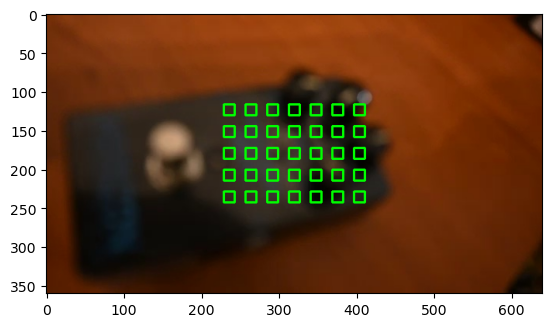

In [28]:
modified_5x7, points_5x7 = get_focus_matrix(original, rects_i=5, rects_j=7, dj=7, di=7)
plt.imshow(modified_5x7)

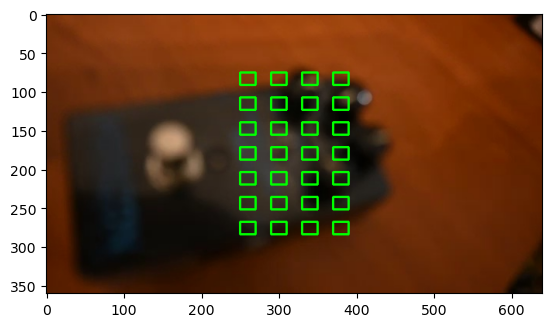

In [29]:
modified_7x4, points_7x4 = get_focus_matrix(original, rects_i=7, rects_j=4, dj=10, di=8)
plt.imshow(modified_7x4)

Ahora que los puntos están definidos, se debe definir un criterio sobre como agrupar por frame los distintos Image Quality Measure obtenidos. 

En este caso, se optó por el promedio ya que mínimo y máximo dieron resultados con demasiado ruido.

In [30]:
from utils import group_metric

In [31]:
metrics_7x7 = [group_metric(frame, points_7x7, image_quality_measure, np.mean) for frame in frame_paths]

0.9099333610995417

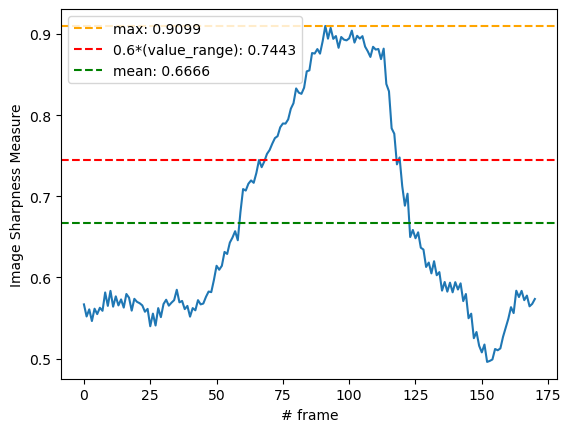

In [32]:
plot_metric(metrics_7x7)

In [33]:
metrics_5x7 = [group_metric(frame, points_5x7, image_quality_measure, np.mean) for frame in frame_paths]

0.9604956268221575

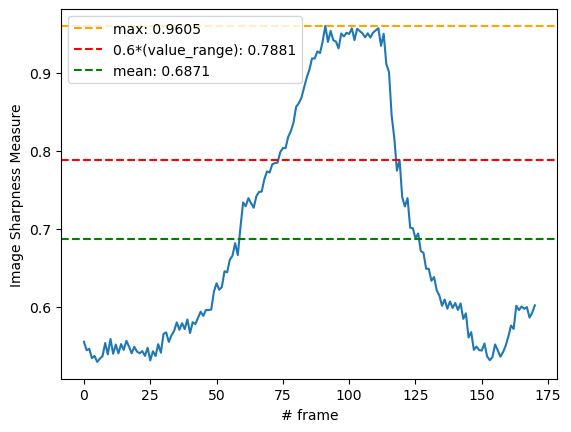

In [34]:
plot_metric(metrics_5x7)

In [35]:
metrics_7x4 = [group_metric(frame, points_7x4, image_quality_measure, np.mean) for frame in frame_paths]

0.8481026785714286

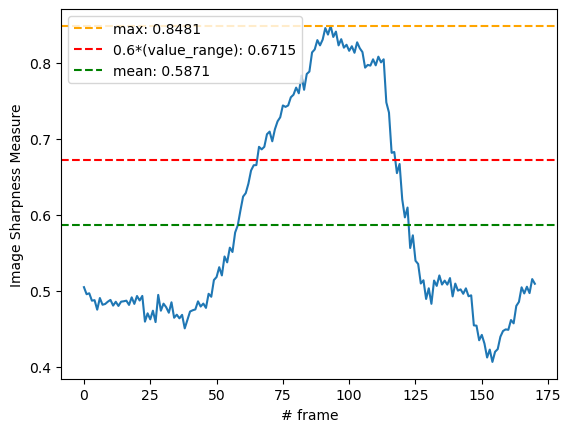

In [36]:
plot_metric(metrics_7x4)

In [37]:
from utils import draw_focus_matrix

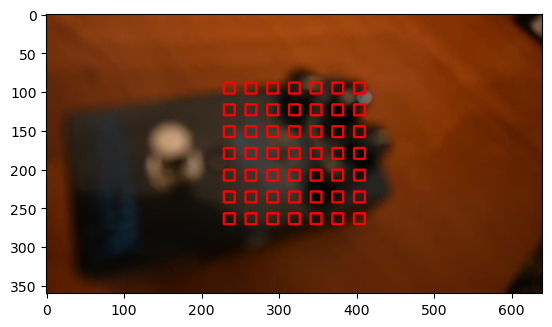

In [38]:
focused_imgs_7x7 = [draw_focus_matrix(frame, get_value_range(metrics_7x4), points_7x7, image_quality_measure) for frame in frame_paths]
plt.imshow(focused_imgs_7x7[0])

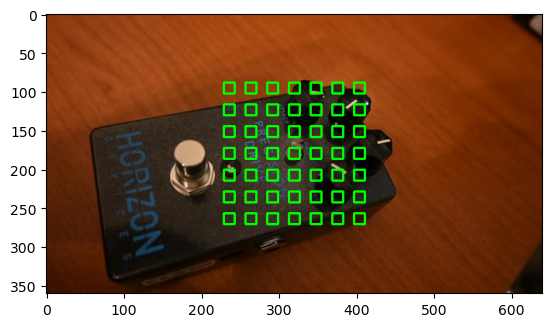

In [39]:
plt.imshow(focused_imgs_7x7[100])

In [40]:
from utils import write_video
write_video(filename='output_7x7.mp4',rgb_frames=focused_imgs_7x7, fps=fps) 

### 2.

#### Brenners focus measure

$$
Brenner(I) = \sum_{x=1}^{M} \sum_{y=1}^{N-2} \left( I(x, y+2) - I(x, y) \right)^2
$$##### Pasos principales:
- Gradiente en la dirección vertical: Se considera la diferencia en intensidades de píxeles en columnas desplazadas por 2 unidades (es decir, I(x,y+2)−I(x,y)).
- Cuadrado de las diferencias: Esto ayuda a magnificar las diferencias significativas y evitar la cancelación de valores negativos.
- Suma acumulativa: Se suman todas las diferencias cuadradas para obtener una métrica global del enfoque de la imagen.

##### Ventajas:
- Simplicidad: Fácil de implementar debido a su dependencia de diferencias locales entre píxeles.
- Eficiencia: Computacionalmente ligero comparado con métodos más complejos basados en frecuencias.

##### Limitaciones:
- Ruido: Es sensible al ruido en la imagen, ya que este también genera gradientes significativos.
- Direccionalidad: El método se centra en un eje específico (horizontal o vertical), por lo que puede perder información de otras direcciones.
- No distingue bordes naturales de artefactos: Esto puede resultar en falsos positivos en términos de enfoque.


In [41]:
def brenner_focus_measure(gray_img):
    shifted_img = np.roll(gray_img, 2, axis=1)
    diff = gray_img - shifted_img
    brenner_measure = np.sum(diff**2)
    return brenner_measure / gray_img.size

In [42]:
metrics_7x7_brenner = [group_metric(frame, points_7x7,brenner_focus_measure, np.mean) for frame in frame_paths]

40.794877134527276

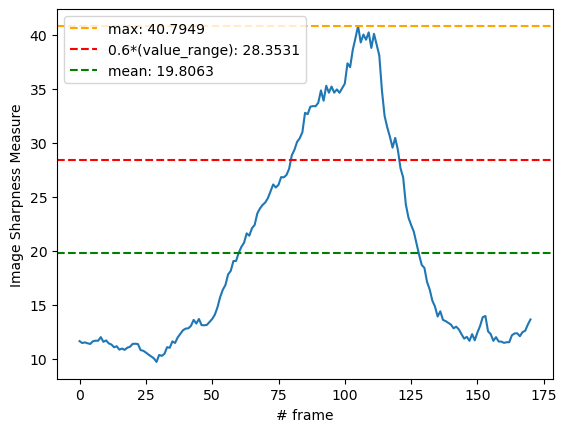

In [43]:
plot_metric(metrics_7x7_brenner)

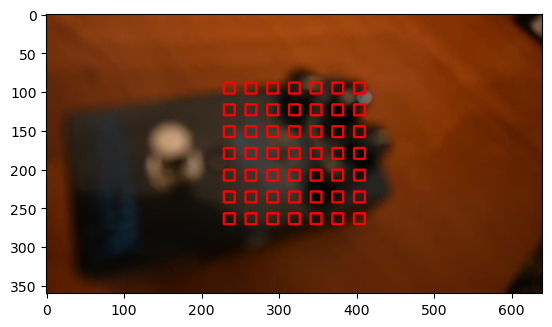

In [44]:
brenner_focus_image = [draw_focus_matrix(frame, 0.7 * np.max(metrics_7x7_brenner), points_7x7,brenner_focus_measure) for frame in frame_paths]
plt.imshow(brenner_focus_image[0])

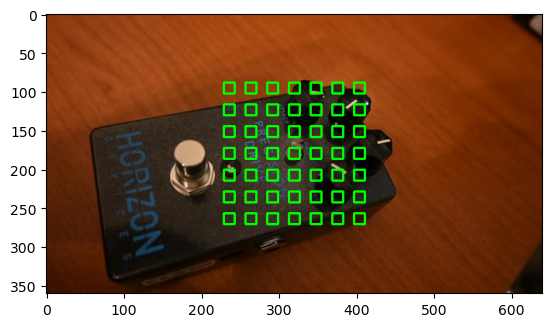

In [45]:
plt.imshow(brenner_focus_image[100])

In [46]:
write_video('output_brenner.mp4', brenner_focus_image, fps) 

#### Spacial frecuency measure

In [47]:
def spatial_frequency(image):
    Ix = np.diff(image, axis=1)
    Iy = np.diff(image, axis=0)
    return np.sqrt(np.sum(Ix ** 2) + np.sum(Iy ** 2))

90.52614892933659

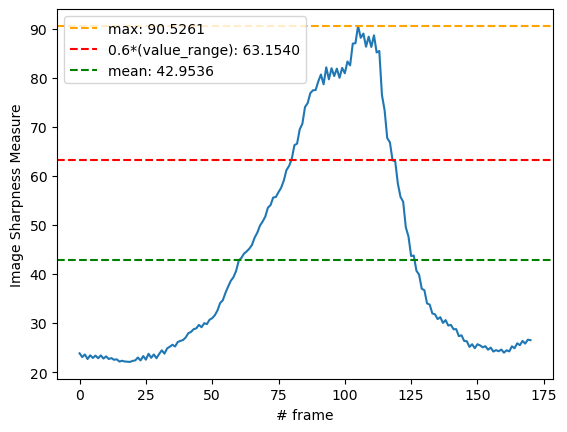

In [48]:
metrics_7x7_sf = [group_metric(frame, points_7x7, spatial_frequency, np.mean) for frame in frame_paths]
plot_metric(metrics_7x7_sf)

In [49]:
sf_focus_image = [draw_focus_matrix(frame, 0.7 * np.max(metrics_7x7_sf), points_7x7, spatial_frequency) for frame in frame_paths]

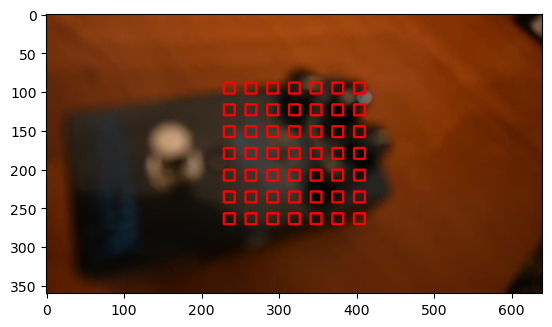

In [50]:
plt.imshow(sf_focus_image[0])

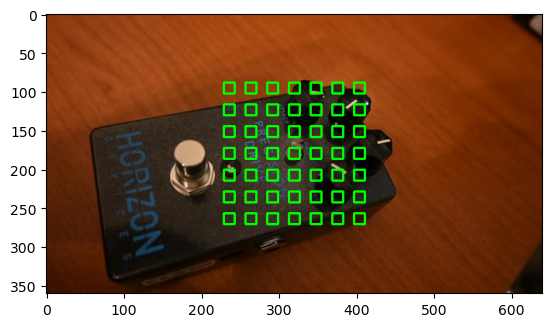

In [51]:
plt.imshow(sf_focus_image[100])

In [52]:
write_video('output_sf.mp4', sf_focus_image, fps) 

### Bonus: Unsharp masking

El algoritmo original tiene como base detectar altas frecuencias, es por eso que al aplicar previamente unsharp masking el cual las resalta, las métricas podrían mejorar.

In [53]:
from skimage.filters import unsharp_mask
def um(img):
    return unsharp_mask(img, radius=10, amount=0.5)

#### Efecto en bajas frecuencias

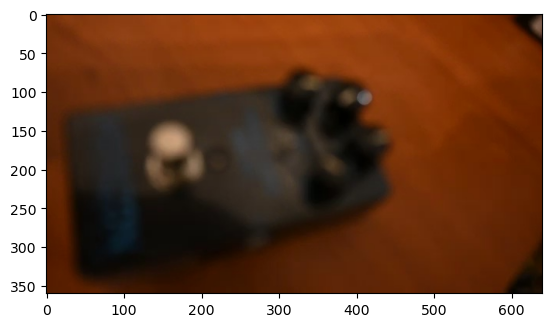

In [54]:
plt.imshow(bgr_to_rgb(frame_paths[0]))

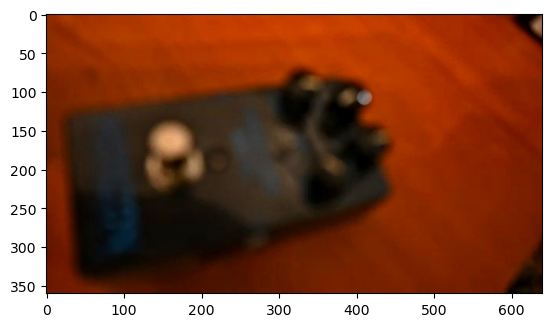

In [55]:
plt.imshow(um(bgr_to_rgb(frame_paths[0])))

#### Efecto en altas frecuencias

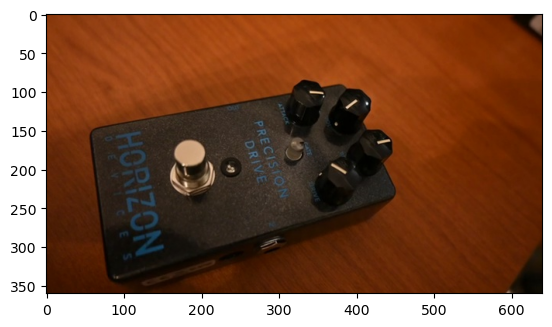

In [56]:
plt.imshow(bgr_to_rgb(frame_paths[100]))

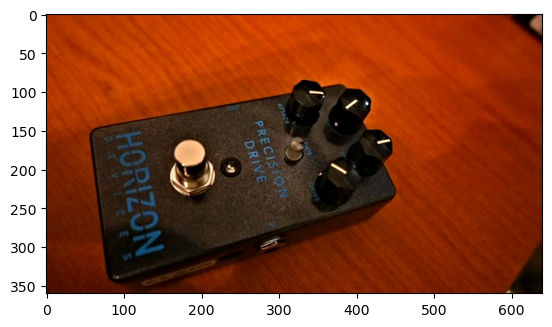

In [57]:
plt.imshow(um(bgr_to_rgb(frame_paths[100])))

In [58]:
metrics_um = [image_quality_measure(um(get_gray_img(cv2.imread(frame)))) for frame in frame_paths]

#### Comparación métricas antes y después de unsharp masking.



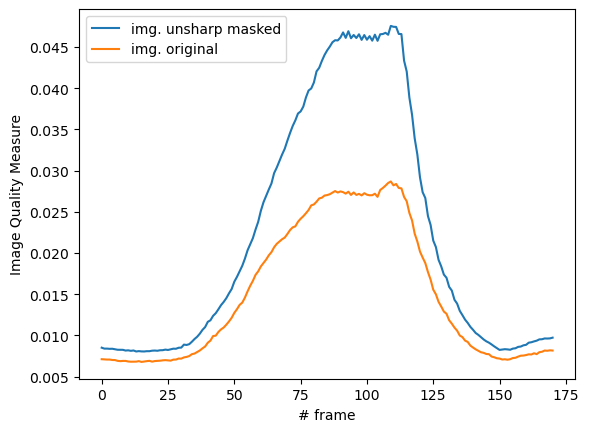

In [59]:
plt.plot(metrics_um, label='img. unsharp masked')
plt.plot(metrics, label='img. original')
plt.xlabel('# frame')
plt.ylabel('Image Quality Measure')
plt.legend()

Se puede ver entonces que el filtro implementado tiene mayor efecto sobre las frecuencias altas, es decir, cuando está enfocado.

In [60]:
def um_tx(img):
    return (um(img)*255).astype(np.uint8)

In [61]:
metrics_roi_5_um = [get_metric_for_centered_roi(um_tx(cv2.imread(frame)), image_quality_measure, 0.05) for frame in frame_paths]

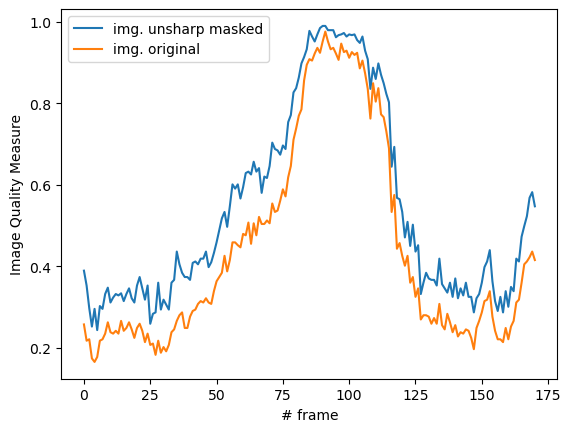

In [62]:
plt.plot(metrics_roi_5_um, label='img. unsharp masked')
plt.plot(metrics_roi_5_percent, label='img. original')
plt.xlabel('# frame')
plt.ylabel('Image Quality Measure')
plt.legend()

In [63]:
metrics_7x7_um = [group_metric(frame, points_7x7, image_quality_measure, np.mean, um_tx) for frame in frame_paths]

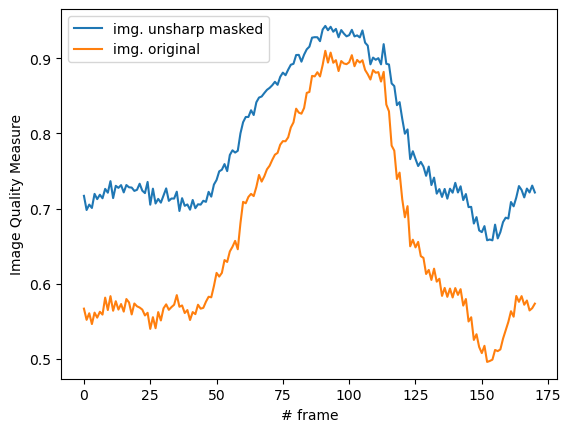

In [64]:
plt.plot(metrics_7x7_um, label='img. unsharp masked')
plt.plot(metrics_7x7, label='img. original')
plt.xlabel('# frame')
plt.ylabel('Image Quality Measure')
plt.legend()

In [65]:
focused_um = [draw_focus_matrix(frame, get_value_range(metrics_7x7_um), points_7x7, image_quality_measure, um_tx) for frame in frame_paths]
write_video('output_unsharp_masking.mp4', focused_um, fps)